# LDA using pwdb textual data's noun phrases

### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim
from gensim.models import TfidfModel, LdaModel, CoherenceModel, Phrases
from gensim.utils import simple_preprocess
import pyLDAvis.gensim_models

from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud
from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_remove_stopwords

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


### Data extraction

In [2]:
pwdb = Dataset.PWDB.fetch()

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100% (1288 of 1288) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [4]:
pwdb_descriptive_data = pwdb['title'].map(str) + ' ' + \
                        pwdb['background_info_description'].map(str) + ' ' + \
                        pwdb['content_of_measure_description'].map(str) + ' ' + \
                        pwdb['use_of_measure_description'] + ' ' + \
                        pwdb['involvement_of_social_partners_description']

pwdb_descriptive_data

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



_id
adc5c75937bc7f7198f534d08b85bd50c9521bfd3f319a090932b5d0bae54de0    Agreement on a teleworking regime During the C...
2372d71eb9ad6e6a70982e02bbe802db004ed49d91b2264c0a2e8e41571002cc    Special protection for COVID-19 risk groups at...
8735e268191e9e5cbd3d2a44ca53d297e31746b5f1e24b941db6225a25848353    Funds for innovative renewable projects in And...
18bcd22116c46919e03a3345f793c3859855227ac942e69dd13cbfcd588e1044    Waiver of advance payments for social and heal...
b94d8aa95fbdeb1bb832b01fbe5d6e9bf9fc36fceb14f7ba370a963f472fe35b    Financial Shield 2.0: Small and medium-sized e...
                                                                                          ...                        
cb014a456b14c3621dd318a12e611f70c2a9636be9fe181072bd4bf5917a40fa    Automatic extension of unemployment benefits D...
d233b17dc2b98f14269c2b22be78d93ec5ccf2a0013b86f09175c69353c5800b    Extra subsidies to institutions in the cultura...
77d7e3c52aaf78bdfb1a1667641db1293bbff862440c547fc3f6

In [5]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                     "[", "]"]
clean_text = clean_text_from_specific_characters(pwdb_descriptive_data, unused_characters)

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



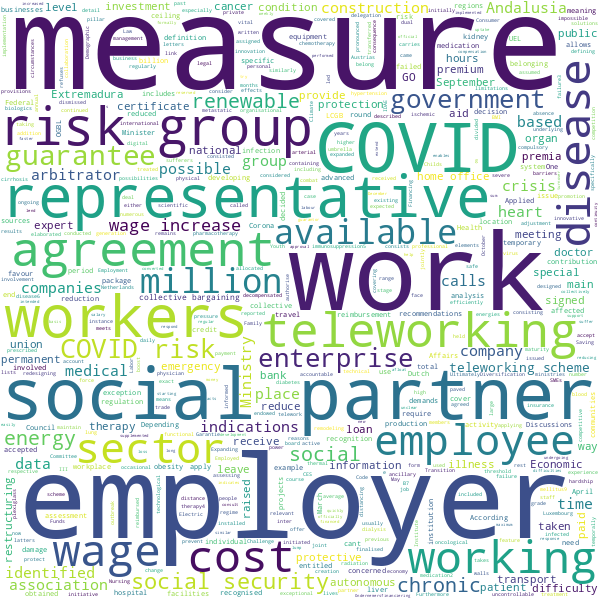

In [19]:
generate_wordcloud(str(clean_text))

### Detect sentences and separate them to words

In [7]:
doc = nlp(clean_text)
sentences = [sentence for sentence in doc.sents]

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [8]:
def convert_sentence_to_words(document: list):
    for sentence in document:
        yield simple_preprocess(str(sentence), deacc=True)

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [10]:
data_words = list(convert_sentence_to_words(sentences))

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Detect pos and set them into a list

In [11]:
def lemmatization(text: list, allowed_postags: list):
    """
        It will detect the selected part of speech from the inserted text
        and set them into a list

        :return: a list with selected part of speech
    """
    texts_out = []
    for sent in text:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Create Dictionary and corpus

In [12]:
id2word = gensim.corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Train LDA Model

In [14]:
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=10,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha="auto")

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### Determine the percentage of perplexity and coherence score

In [17]:
print('Perplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.634702655903207


/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Coherence Score:  0.4453723620499268


In [18]:
pyLDAvis.enable_notebook()
visualize = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds")
visualize

/home/daycu/Work/sem-covid/venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.214190 -0.000135       1        1  13.305678
0     -0.098879  0.049401       2        1  12.979692
6     -0.089000  0.191806       3        1  12.417644
9      0.175079 -0.158949       4        1  12.282162
3      0.144453  0.011303       5        1  10.729010
2      0.151165  0.125797       6        1  10.035116
8      0.029231  0.150104       7        1   8.360922
5     -0.031941 -0.186707       8        1   7.516565
7     -0.115081 -0.107850       9        1   6.794331
4      0.049164 -0.074770      10        1   5.578879, topic_info=           Term      Freq     Total Category  logprob  loglift
99        group  8.000000  8.000000  Default  30.0000  30.0000
292      energy  4.000000  4.000000  Default  29.0000  29.0000
29      partner  8.000000  8.000000  Default  28.0000  28.0000
418      reduce  4.000000  4.000000  Default  27.0000  27.0000
80         take  3.000000  3.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
19     economic  0.584521  2.577657  Topic10  -4.5424   1.4023
27     ministry  0.584521  3.917217  Topic10  -4.5424   0.9838
181  indication  0.584521  3.225906  Topic10  -4.5424   1.1780
187       issue  0.584520  2.498986  Topic10  -4.5424   1.4333
186      doctor  0.584520  2.476075  Topic10  -4.5424   1.4425

[516 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
144       2  0.727588      absence
67        3  0.364192       accept
67        6  0.364192       accept
68        6  0.756214  accountable
371       3  0.731529          act
...     ...       ...          ...
124       2  0.505659    workplace
124       8  0.505659    workplace
82        6  0.756255        write
47        7  0.780566         year
179       2  0.727588        youth

[638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 7, 10, 4, 3, 9, 6, 8, 5])